

# Fast Causal inference

Fast Causal Inference is Tencent's first open-source causal inference project. It is an OLAP-based high-performance causal inference (statistical model) computing library, which solves the performance bottleneck of existing statistical model libraries (R/Python) under big data, and provides causal inference capabilities for massive data execution in seconds and sub-seconds. At the same time, the threshold for using statistical models is lowered through the SQL language, making it easy to use in production environments. At present, it has supported the causal analysis of WeChat-Search, WeChat-Video-Account and other businesses, greatly improving the work efficiency of data scientists.
![Example Image](https://github.com/Tencent/fast-causal-inference/raw/main/docs/images/fast-causal-inference3.png)


# Get started

In [1]:
import time
import pandas as pd

In [2]:
# opensource or in tencent
import fast_causal_inference
fast_causal_inference.set_config(".jupyter/conf.yaml")

sql_instance = fast_causal_inference.create()

# know your data

### test data generation

In [ ]:
import numpy as np
import pandas as pd
import random
# Set random seed for reproducibility
np.random.seed(0)
n = 10000

################################## generate covariables #############################################
# Generate x1-x5, they come from different distributions and have different variances
x1 = np.random.normal(0, 1, n) # Normal distribution, variance is 1
x2 = np.random.normal(0, 2, n)  # Normal distribution, variance is 4
x3 = np.random.exponential(1, n)  # Exponential distribution, variance is 1
x4 = np.random.exponential(2, n)  # Exponential distribution, variance is 4
x5 = np.random.uniform(0, 5, n)  # Uniform distribution, variance is approximately 1.33
weight = np.random.uniform(0, 1, n) # use for sample reweighing

# Generate x6-x7, they are long-tail distributed data
x_long_tail1 = np.random.pareto(3, n)  # Pareto distribution
x_long_tail2 = np.random.pareto(2, n)  # Pareto distribution

# Generate x_cat1, it is a discrete variable of string type
x_cat1 = np.random.choice(['A', 'B', 'C', 'D', 'E'], n)
###################################################################################################### 



################################## generate exprimental data ######################################### 
# Generate treatment, it is a binary random variable
treatment = np.random.choice([0, 1], n)


# Generate y 
# y is highly correlated with x1, x2, x3,x_long_tail2 and treatment
# and there is heterogeneity on x_cat1 and x1,x2,x4
y_pre = x1 + 2*x2 + 3*x3 + 3*np.log(x_long_tail2+1) + np.random.normal(0, 1, n)
y = y_pre + 5*treatment + treatment*(x1+x2**2+np.log(x4+1)+(x_long_tail1>1))*2 + np.random.normal(0, 2, n)
y[x_cat1 == 'A'] += 3
y[x_cat1 == 'B'] -= 2

# Generate ratio metric: numerator/denominator, for example click/show
numerator_pre = y_pre 
numerator = y 
denominator_pre = x1 + 2*x5 + 3*np.log(x_long_tail1+1) + np.random.normal(0, 1, n)
denominator = denominator_pre + 2*treatment + treatment*(x1)*2 + np.random.normal(0, 2, n)
###################################################################################################### 


################################## generate observational data ####################################### 
# use x1,x2,x3 before
# Generate linear combination for t_ob
linear_combination_t = 1*x1 + 0.2*x2 + 0.5 * x3 + 0.1 * np.random.normal(0, 1, n)

# Convert the linear combination into a probability using the logistic function
prob_t = 1 / (1 + np.exp(-linear_combination_t))

# Generate binary variable t based on the probability
t_ob = np.random.binomial(1, prob_t)

# Generate linear combination for y
linear_combination_y = 0.5 * x1 - 0.25 * x2 + 0.1 * x3 + 0.5 * t_ob + 0.1 * np.random.normal(0, 1, n)

# Generate target variable y
y_ob = linear_combination_y + np.random.normal(0, 1, n)
###################################################################################################### 



# get DataFrame
df = pd.DataFrame({
    'x1': x1,
    'x2': x2,
    'x3': x3,
    'x4': x4,
    'x5': x5,
    'x_long_tail1': x_long_tail1,
    'x_long_tail2': x_long_tail2,
    'x_cat1': x_cat1,
    'treatment': treatment,
    't_ob':t_ob,
    'y': y,
    'y_ob': y_ob,
    'numerator_pre':numerator_pre,
    'numerator':numerator,
    'denominator_pre':denominator_pre,
    'denominator':denominator,
    'weight' : weight
})


# show data 
print(df.head())

Covariables

- `x1`: This variable follows a normal distribution with a mean of 0 and a variance of 1.
- `x2`: This variable also follows a normal distribution, but with a mean of 0 and a larger variance of 4.
- `x3`: This variable is generated from an exponential distribution with a rate parameter of 1, resulting in a variance of 1.
- `x4`: Similar to `x3`, this variable is generated from an exponential distribution, but with a larger rate parameter of 2, resulting in a variance of 4.
- `x5`: This variable is generated from a uniform distribution between 0 and 5, with an approximate variance of 1.33.
- `weight`: This variable is generated from a uniform distribution between 0 and 1 and can be used for sample reweighing.
- `x_long_tail1`: This variable follows a Pareto distribution with a shape parameter of 3, representing a long-tailed distribution.
- `x_long_tail2`: Similarly, this variable follows a Pareto distribution with a shape parameter of 2.
- `x_cat1`: This variable is a discrete variable of string type, randomly chosen from the categories 'A', 'B', 'C', 'D', and 'E'.

Experimental data
- `treatment`: This variable represents the treatment assignment and is a binary random variable.

- `y`: The target variable `y` is highly correlated with `x1`, `x2`, `x3`, `x_long_tail2`, and `treatment`. There is also heterogeneity in the relationship with `x_cat1` and `x1`, `x2`, `x4`. It is generated by adding `y_pre` with treatment effects, interaction terms, and random noise.

- `numerator_pre`: This variable is a precursor to the numerator of a ratio metric and is highly correlated with `y_pre`.

- `numerator`: The numerator of the ratio metric is derived from `numerator_pre` and is highly correlated with `y`.

- `denominator_pre`: This variable is a precursor to the denominator of a ratio metric and is generated based on `x1`, `x5`, and `x_long_tail1`.

- `denominator`: The denominator of the ratio metric is derived from `denominator_pre` and is influenced by treatment effects, interaction terms with `x1`, and random noise.

Observational data 
- `t_ob`: This binary variable is generated based on a linear combination of `x1`, `x2`, and `x3`. The linear combination is converted into a probability using the logistic function, and `t_ob` is generated by sampling from a binomial distribution with the probability.

- `y_ob`: The target variable `y_ob` is generated based on a linear combination of `x1`, `x2`, `x3`, and `t_ob`, along with random noise. It represents the outcome variable in the observational data.


### data description

In [19]:
table = 'test_data_small'
sql_instance.sql(f"select * from {table} limit 5;")

,id,x1,x2,x3,x4,x5,x_long_tail1,x_long_tail2,x_cat1,treatment,t_ob,y,y_ob,numerator_pre,numerator,denominator_pre,denominator,weight,day_
0,b007dbf3-6fe2-4901-8000-16de17fad502,1.7505385834329148,0.39106792677974656,1.72425125498992,0.2888412152852525,0.7971701362972877,0.11649901928342854,0.11756334027631477,D,1,1,17.686170977579746,1.836945974012858,8.000044993752281,17.686170977579746,4.796570927220992,11.66781041572295,0.9850482308229433,2023-11-03
1,fedda0ed-e19d-42ca-8000-1bdf733ffd9c,-1.2817332289206058,0.5876971861761044,1.438891002640861,2.5250317640166244,0.014143904902794158,3.1337925579612884,0.015274302847965604,E,1,0,12.024427422475613,-0.3019925295255651,5.33552518400478,12.024427422475613,4.663767996485404,4.398090953517113,0.3034259187982715,2023-11-03
2,d126d228-1372-4774-8002-39f527ff6c4c,1.5450384410672113,0.004286824048081505,0.1029724620891589,2.54703100730822,0.19845747204751574,0.20832798616408854,0.2707802495985492,B,0,1,-1.525981422224525,0.5114373786530622,3.1924778734897656,-1.525981422224525,1.9299996938762858,5.938695571216891,0.8429913211299445,2023-11-03
3,c9f50c68-931d-418e-8003-6c9f18b08a0b,0.8439826878597811,-2.539776347083615,2.2333465531019865,1.9012159237867055,2.4196434792199115,0.07992082555816693,0.5343770114728588,C,1,1,27.10522922247133,1.1443261471891566,4.452601227539352,27.10522922247133,6.47445215322303,9.547153116086074,0.790054676298481,2023-11-03
4,6d857229-9b51-40d3-8004-607763bd1cb6,-0.044952193373201055,-2.11749115099508,1.253902331961399,9.294157462760747,2.9284128756152716,1.4688302939410547,0.4879176556075999,A,0,1,3.943177897485132,2.6782919269832592,-0.5366725357045548,3.943177897485132,7.193531174439597,7.130297093815557,0.2923574974092905,2023-11-03


In [20]:
# data descirption
from fast_causal_inference.lib.tools import *
table = 'test_data_small'
describe(table,'*')

The type of id is not numeric
The type of x_cat1 is not numeric
The type of day_ is not numeric


,count,std,min,quantile_0.25,quantile_0.5,quantile_0.75,quantile_0.90,quantile_0.99,max
x1,1000000.0,0.999922,-5.002299e+00,-0.679415,0.019157,0.684455,1.283479,2.303482,4.716662
x2,1000000.0,1.997773,-9.641880e+00,-1.318027,-0.005142,1.373938,2.617899,4.648914,9.592931
x3,1000000.0,1.000620,3.675154e-07,0.286188,0.687187,1.396347,2.305995,4.569158,14.140199
x4,1000000.0,2.000650,5.033568e-08,0.573155,1.395479,2.812585,4.609905,8.872086,28.353437
x5,1000000.0,1.442778,1.376244e-05,1.268528,2.474817,3.702746,4.474466,4.949631,4.999999
x_long_tail1,1000000.0,0.854935,1.282535e-07,0.099149,0.257353,0.582168,1.125456,3.439402,74.090720
x_long_tail2,1000000.0,4.201436,1.635832e-06,0.154003,0.407520,0.986300,2.179218,9.388923,2702.431606
treatment,1000000.0,0.500000,0.000000e+00,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
t_ob,1000000.0,0.490887,0.000000e+00,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
y,1000000.0,12.696355,-1.941695e+01,3.979017,9.869640,17.367961,27.518491,57.510296,215.601467


#### histplot

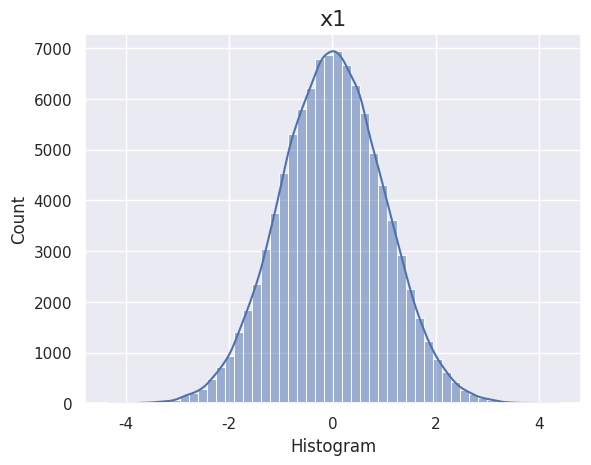

The type of x_cat1 is not numeric


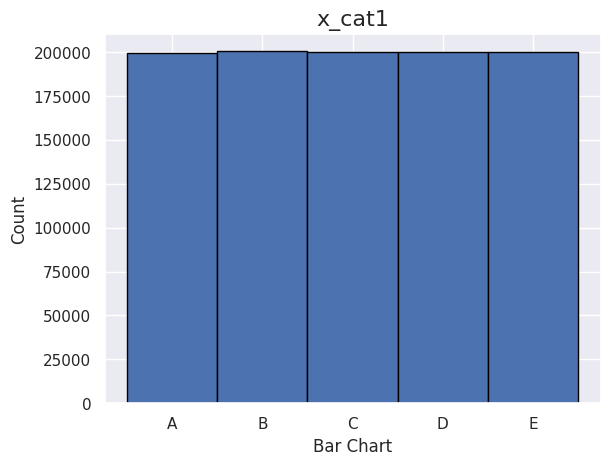

In [21]:
# histplot

from fast_causal_inference.lib.tools import *
table = 'test_data_small'
col = 'x1'
histplot(table,col,bin_num=50)

table = 'test_data_small'
col = 'x_cat1'
histplot(table,col,bin_num=50)

#### boxplot

min: 1.2825348871814413e-07
25_quantile: 0.09646150862134684
50_quantile: 0.2535869458656722
75_quantile: 0.5855107918153533
max: 74.09071953982661


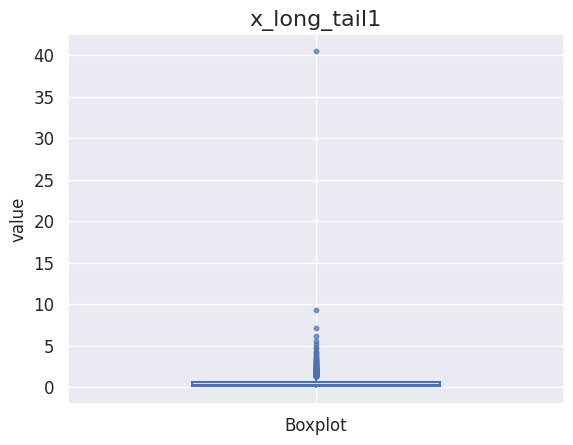

In [22]:
# boxplot

from fast_causal_inference.lib.tools import *

table = 'test_data_small'
col = 'x_long_tail1'
boxplot(table,col)

# AB experiment Analysis

### ttest

- In A/B test analysis, **t-test** is widely used to test whether the average of treatment variant is statistically significantly different from the average of the control variant. However, the mean and variance formula only applied to i.i.d (independent and identically distributed) random variables, and in real business cases our metrics are more complex. Mostly, business metrics are defined as ratios, for example, Clickthrough rate or CTR which is defined as Clicks/Views. Here, we will *utilize the delta method to approximate the variance of the metrics ratio*.
$$t=\frac{\bar X_B-\bar X_A}{\sqrt{Var(\bar X_A)+Var(\bar X_B)}}$$

$$Var(\bar X)=\frac{1}{n}\frac{1}{n-1}\sum_{i=1}^n (X_i-\bar X)^2 $$
- **Delta method** extends the normal approximations of the central limit theorem. Delta method approximates asymptotically normal random variables by applying the Taylor series on the function of random variables. We can estimate the variance of x/y as follows:
$$v=(1/y,-x/y^2)|_{x=\bar x, y=\bar y )}$$

$$\mathop{{M}}\nolimits_{{2 \times 2}}=\frac{1}{n}{ \left[ {\begin{array}{*{20}{c}}
{var(x)}&{cov(x,y)}\\
{cov(x,y)}&{var(y)}\\
\end{array}} \right] }={ \left[ {\mathop{{m}}\nolimits_{{ij}}} \right] }  $$

$$var(x/y)=v*\mathop{{M}}\nolimits_{{2 \times 2}}*v$$

- <font size="4">case1: use deltamethod to do t-test</font>

In [23]:
ttest = sql_instance.sql("""select 
                                  ttest_2samp(avg(numerator)/avg(denominator),treatment,'two-sided') as ttest_result
                            from 
                                  test_data_small""")
fast_causal_inference.to_pandas(ttest['ttest_result'])

,mean0,mean1,estimate,stderr,t-statistic,p-value,lower,upper
0,0.780409,2.472226,1.691817,0.003286,514.839199,0.000000,1.685376,1.698257


- <font size="4">case2: use deltamethod to do t-test and **CUPED** to reduce variance</font>  


    - We offer a feature in ttest_2samp that utilizes [CUPED (Controlled-experiment Using Pre-Experiment Data)](https://ai.stanford.edu/~ronnyk/2013-02CUPEDImprovingSensitivityOfControlledExperiments.pdf) This technique adjusts metrics using pre-experiment data from both control and treatment groups, aiming to decrease metric variability.
    - To further reduce variance, you can combine multiple metrics using the '+' operator.
    - Additionally, ttest_2samp allows you to perform a t-test grouped by any dimensions of your choice.

In [24]:
ttest = sql_instance.sql("""select 
                                  ttest_2samp(avg(numerator)/avg(denominator),treatment,'two-sided',
                                  avg(numerator_pre)/avg(denominator_pre)+avg(x1)) as ttest_result 
                            from 
                                  test_data_small""")
fast_causal_inference.to_pandas(ttest['ttest_result'])

,mean0,mean1,estimate,stderr,t-statistic,p-value,lower,upper
0,0.782153,2.470484,1.688330,0.002567,657.654079,0.000000,1.683299,1.693362


In [25]:
ttest = sql_instance.sql("""select 
                                  x_cat1,ttest_2samp(avg(numerator)/avg(denominator),treatment,'two-sided',
                                  avg(numerator_pre)/avg(denominator_pre)) as ttest_result 
                            from 
                                  test_data_small
                            group by 
                                  x_cat1""")
fast_causal_inference.to_pandas(ttest['ttest_result'])

,mean0,mean1,estimate,stderr,t-statistic,p-value,lower,upper
0,0.418431,2.193052,1.774621,0.005475,324.157289,0.000000,1.763891,1.785351
1,0.744301,2.438846,1.694545,0.005731,295.694917,0.000000,1.683313,1.705777
2,0.747373,2.447231,1.699857,0.005769,294.665887,0.000000,1.688551,1.711164
3,0.753375,2.450852,1.697476,0.005794,292.976337,0.000000,1.686121,1.708832
4,1.247141,2.827787,1.580646,0.006380,247.752362,0.000000,1.568141,1.593150


- <font size="4">case3: ttest_1samp </font>  
    - ttest_1samp can be used in pair test.


In [26]:
ttest = sql_instance.sql("""select 
                                  ttest_1samp(avg(numerator)/avg(denominator),'two-sided') as ttest_result
                            from 
                                  test_data_small""")
fast_causal_inference.to_pandas(ttest['ttest_result'])

,estimate,stderr,t-statistic,p-value,lower,upper
0,1.747235,0.001908,915.730622,0.000000,1.743495,1.750975


### MWU test

The [Mann–Whitney U test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) is a nonparametric test of the null hypothesis that, for randomly selected values X and Y from two populations, the probability of X being greater than Y is equal to the probability of Y being greater than X.

In [27]:
sql_instance.sql("""
    select 
        mannWhitneyUTest('two-sided')(numerator, treatment) 
    from 
        test_data_small;
""")

,"mannWhitneyUTest('two-sided')(numerator, treatment)"
0,"[2.3984680203E10, 0.0]"


### SRM

**SRM (Sample ratio mismatch)** is an experimental flaw where the expected traffic allocation doesn’t fit with the observed visitor number for each testing variation. We do this using the chi-squared test of independence.

In [28]:
result = sql_instance.sql("""SELECT  
                                   SRM(1, treatment, [1,1]) as srm
                            FROM  
                                   test_data_small""")
fast_causal_inference.to_pandas(result['srm'])

,groupname,f_obs,ratio,chisquare,p-value
0,0,4.9946e+05,1.000000,1.170724,0.279253
1,1,5.0054e+05,1.000000,None,None


# Regression-based model

### Linear regression

In statistics, [linear regression](https://en.wikipedia.org/wiki/Linear_regression) is a linear approach for modelling the relationship between a scalar response and one or more explanatory variables (also known as dependent and independent variables). The case of one explanatory variable is called simple linear regression. Written in matrix notation as:
$$y=X\beta+\epsilon$$

#### OLS

In statistics, [ordinary least squares (OLS)](https://en.wikipedia.org/wiki/Ordinary_least_squares) is a type of linear least squares method for choosing the unknown parameters in a linear regression model (with fixed level-one effects of a linear function of a set of explanatory variables) by the principle of least squares: minimizing the sum of the squares of the differences between the observed dependent variable (values of the variable being observed) in the input dataset and the output of the (linear) function of the independent variable.
$$S(\boldsymbol{\beta}) = \sum_{i=1}^n \left| y_i - \sum_{j=1}^p X_{ij}\beta_j\right|^2 = \left\|\mathbf y - \mathbf{X} \boldsymbol \beta \right\|^2.$$
We can leverage **matrix multiplication** to compute Ordinary Least Squares (OLS), which is highly efficient in the OLAP engine we are using.
$$\hat{\boldsymbol{\beta}} = \left( \mathbf{X}^{\operatorname{T}} \mathbf{X} \right)^{-1} \mathbf{X}^{\operatorname{T}} \mathbf y.$$


In [3]:
# ols
result = sql_instance.sql(f"""SELECT 
                                    ols(y~x1+x2) AS res
                              FROM
                                    test_data_small""")
print(result['res'][0])



Call:
  lm( formula = y ~ x1 + x2 )

Coefficients:
.               Estimate    Std. Error  t value     Pr(>|t|)    
(Intercept)     12.240031   0.011883    1030.041644 0.000000    
x1              1.965743    0.011884    165.411347  0.000000    
x2              2.009595    0.005948    337.852522  0.000000    

Residual standard error: 11.883031 on 999997 degrees of freedom
Multiple R-squared: 0.124017, Adjusted R-squared: 0.124016
F-statistic: 70787.441742 on 2 and 999997 DF,  p-value: 0.000000



In [4]:
# predict
sql_instance.sql(f"""SELECT
                            predict(olsState(y+x1+x2),x1,x2) AS res
                      FROM
                            test_data_small
                      limit 10""")

,res
0,16.467028425343486
1,10.90150596913265
2,15.28579465708971
3,8.795163143643663
4,7.896367586936329
5,9.933836791930506
6,14.0388010978234
7,12.758258539132141
8,6.01535143833402
9,10.720462874727595


#### WLS

[Weighted least squares (WLS)](https://en.wikipedia.org/wiki/Weighted_least_squares), also known as weighted linear regression,[1][2] is a generalization of ordinary least squares and linear regression in which knowledge of the unequal variance of observations (heteroscedasticity) is incorporated into the regression. WLS is also a specialization of generalized least squares, when all the off-diagonal entries of the covariance matrix of the errors, are null.
$$  \underset{\boldsymbol\beta}{\operatorname{arg\ min}}\, \sum_{i=1}^{n} w_i \left|y_i - \sum_{j=1}^{m} X_{ij}\beta_j\right|^2 =
  \underset{\boldsymbol\beta}{\operatorname{arg\ min}}\, \left\|W^\frac{1}{2}\left(\mathbf{y} - X\boldsymbol\beta\right)\right\|^2.$$
We can leverage **matrix multiplication** to compute Weighted least squares (WLS), which is highly efficient in the OLAP engine we are using.
$$\hat{\boldsymbol{\beta}} = (X^\textsf{T} W X)^{-1} X^\textsf{T} W \mathbf{y}.$$

In [5]:
result = sql_instance.sql(f"""SELECT
                                    wls(y~x1+x2,weight) as res
                              from 
                                    test_data_small""")
print(result['res'][0])


Call:
  lm( formula = y ~ x1 + x2 )

Coefficients:
.               Estimate    Std. Error  t value     Pr(>|t|)    
(Intercept)     12.244710   0.011889    1029.887762 0.000000    
x1              1.958339    0.011886    164.762589  0.000000    
x2              1.996484    0.005950    335.525719  0.000000    

Residual standard error: 8.406608 on 999997 degrees of freedom
Multiple R-squared: 0.111087, Adjusted R-squared: 0.111086
F-statistic: 62484.746748 on 2 and 999997 DF,  p-value: 0.000000



#### Lasso

**Lasso (Least Absolute Shrinkage and Selection Operator)** is a method used in regression analysis that performs both variable selection and regularization. This enhances the prediction accuracy and interpretability of the statistical model it produces. Lasso introduces a penalty term to the loss function of the least square method, which is the absolute value of the magnitude of the coefficients. This results in some coefficients being shrunk to zero, effectively selecting a simpler model that does not include those coefficients. To estimate Lasso, we use **gradient descent**, an optimization algorithm.


In [6]:
# 训练
result = sql_instance.sql(f"""SELECT
                                stochasticLinearRegression(0.001, 0.1, 15, 'Lasso')(y, x1, x2, x3) as res
                           FROM
                                test_data_small""")
print(result['res'][0])

[1.2558144538605551,2.0767084785308247,4.464278423215914,5.300328509526717]


### logistic model

In statistics, the [logistic model (or logit model)](https://en.wikipedia.org/w/index.php?title=Logistic_regression) is a statistical model that models the probability of an event taking place by having the log-odds for the event be a linear combination of one or more independent variables. In regression analysis, logistic regression (or logit regression) is estimating the parameters of a logistic model (the coefficients in the linear combination). To estimate logistic model, we use **gradient descent**, an optimization algorithm.

$$p(x)=\frac{1}{1+e^{-(\beta_0+\beta_1 x)}}$$

In [7]:
table = 'test_data_small'
X = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_long_tail1', 'x_long_tail2']
T = 't_ob'
sql_instance.sql(f""" WITH(

          SELECT 
                    stochasticLogisticRegressionState(0.1, 1.0, 100, 'SGD')({T},{','.join(X)}) AS model
          FROM
                    {table}
         )AS model
         
        SELECT            
                evalMLMethod(model,{','.join(X)}) AS score
            FROM
                  {table}
            limit 200
          """)


,score
0,0.7866036793280557
1,0.8055227995470602
2,0.7944019519557489
3,0.8350165824588831
4,0.9091967730873669
...,...
195,0.7567764322954337
196,0.8630619367387724
197,0.8004741396871344
198,0.8694932785057746


### IV


[instrumental variables (IV)](https://en.wikipedia.org/wiki/Instrumental_variables_estimation) is a method used in statistics, econometrics, epidemiology, and related disciplines to estimate causal relationships when controlled experiments are not feasible or when a treatment is not successfully delivered to every unit in a randomized experiment. 

The idea behind IV is to use a variable, known as an instrument, that is correlated with the endogenous explanatory variables (the variables that are correlated with the error term), but uncorrelated with the error term itself. This allows us to isolate the variation in the explanatory variable that is purely due to the instrument and thus uncorrelated with the error term, which can then be used to estimate the causal effect of the explanatory variable on the dependent variable.

Here is an example:

1. $t_1 = treatment + X_1 + X_2$
2. $Y = \hat t_1 + X_1 + X_2$

- $X_1$ and $X_2$ are independent variables or predictors.
- $t_1$ is the dependent variable that you are trying to explain or predict.  
- $treatment$ is an independent variable representing some intervention or condition that you believe affects $t_1$. 
- $Y$ is the dependent variable that you are trying to explain or predict
-  $\hat t_1$ is the predicted value of $t_1 from the first equation


We first regress $X_3$ on the treatment and the other exogenous variables $X_1$ and $X_2$ to get the predicted values $\hat t_1$. Then, we replace $t_1$ with $\hat t_1$ in the second equation and estimate the parameters. This gives us the causal effect of $t_1$ on $Y$, purged of the endogeneity problem.

In [8]:
# iv 
iv = sql_instance.sql("""
                        SELECT
                              ivregression(y~(t_ob~treatment)+x1+x2) as iv
                        FROM
                              test_data_small""")
print(iv["iv"][0])


Call:
  lm( formula = y ~ x1 + x2 + x3 )

Coefficients:
.               Estimate    Std. Error  t value     Pr(>|t|)    
(Intercept)     16270.999658 1687.124423 9.644220    0.000000    
x1              -2.7339e+04 26305.557831 -1.039269   0.298680    
x2              5184.591402 44231.869998 0.117214    0.906691    
x3              1044.770569 8385.157644 0.124598    0.900842    

Residual standard error: 9.182725 on 999996 degrees of freedom
Multiple R-squared: 0.476901, Adjusted R-squared: 0.476900
F-statistic: 303893.684536 on 3 and 999996 DF,  p-value: 0.000000



# Obeservational Analysis

### Case1- PSM

[Propensity score matching (PSM)](https://en.wikipedia.org/wiki/Propensity_score_matching) is a quasi-experimental method in which the researcher uses statistical techniques to construct an artificial control group by matching each treated unit with a non-treated unit of similar characteristics. Using these matches, the researcher can estimate the impact of an intervention.
![Example Image](https://builtin.com/sites/www.builtin.com/files/styles/ckeditor_optimize/public/inline-images/1_propensity-score-matching.jpeg)

#### predict propensity score

Once we have collected the data, we can build the propensity model predicting the probability of receiving the treatment given the confounders. Typically, logistic regression is used for this classification model. Let’s build a propensity model:

In [56]:
import fast_causal_inference
Y='y'
T='t_ob'
table = 'test_data_small'
X = [ 'x1', 'x2', 'x3']


In [63]:
import time
table_output = f"{table}_{int(time.time())}"

fast_causal_inference.clickhouse_create_view(clickhouse_view_name=table_output, sql_statement=f""" WITH(

          SELECT 
                    stochasticLogisticRegressionState(1, 2, 50, 'SGD')({T},{','.join(X)}) AS model
          FROM
                    {table}
         )AS model
         
SELECT            
                evalMLMethod(model,{','.join(X)}) AS score, *
            FROM
                  {table}
          """, primary_column="score",is_force_materialize=True, is_sql_complete=True, is_use_local=False)



running, please wait
donetime cost: 3.252125937025994 Seconds


#### Matching

We will be performing one-to-one matching to find the most similar control records for each passenger in the treatment group. Matching based on the propensity score, which is a balancing score, allows us to ensure that the distribution of confounders between the matched records is likely to be similar.

In [64]:
table_match = f"{table}_{int(time.time())}_matched"
fast_causal_inference.clickhouse_create_view(clickhouse_view_name=table_match, sql_statement=f"""
select *,caliperMatching(if({T}=1,1,-1),score,0.05) AS matchingIndex 
from {table_output} where matchingIndex!=0 """, primary_column="matchingIndex",is_force_materialize=True, is_sql_complete=True, is_use_local=False)
print("table_match: ",table_match)
print("sample size:",sql_instance.sql(f"select count(*) as cnt from {table_match}").values[0])

running, please wait
donetime cost: 1.114890501019545 Seconds
table_match:  newwwwww_1699005215_matched
sample size: ['6994']


#### Balance check

It’s time to evaluate how good the matching was. Let’s inspect if the groups look more comparable in terms of the confounders:

In [70]:
# before matched
from fast_causal_inference.lib.tools import *
SMD(table_output,T,X)

,Control,Treatment,SMD
x2,-0.364005,0.280263,0.329153
x3,0.778968,1.136712,0.380501
x1,-0.463434,0.279347,0.811724


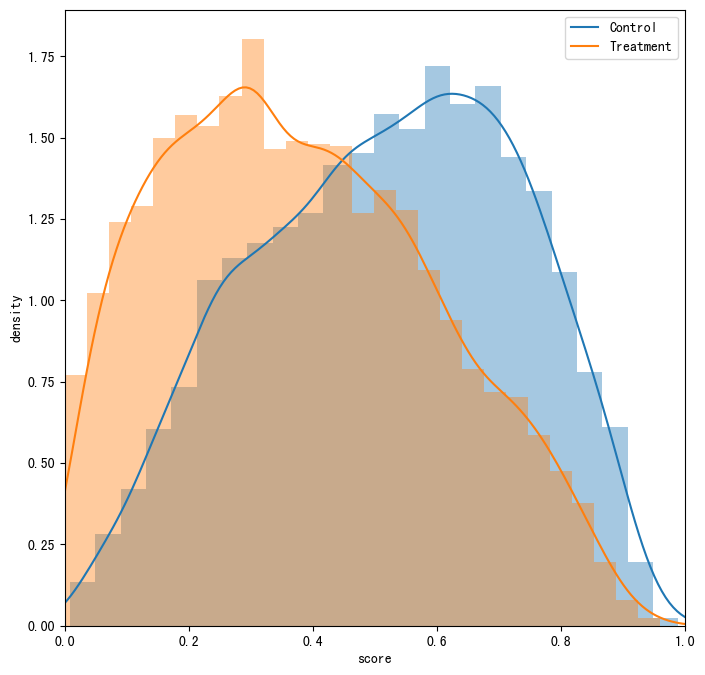

In [66]:
from fast_causal_inference.lib.tools import *
matching_plot(table_output,T,'score')

In [67]:
# After matched
from fast_causal_inference.lib.tools import *
SMD(table_match,T,X)

,Control,Treatment,SMD
x2,-0.055664,-0.333792,-0.149840
x3,0.830524,0.864335,0.041324
x1,-0.457145,0.253599,0.778623


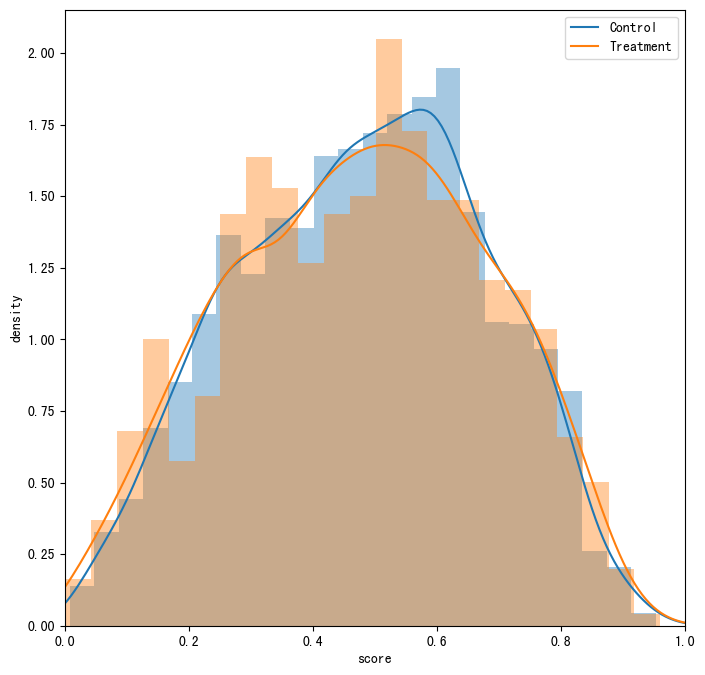

In [68]:
from fast_causal_inference.lib.tools import *
matching_plot(table_match,T,'score')

#### Evaluate treatment effect on the outcome

Now, it’s time to familiarize ourselves with a few terms related to the treatment effect, also known as the causal effect. Looking at a small example with a continuous outcome may be the easiest way to get familiarized with it.
##### DIM estimator
After the matching process, we can consider the experimental and control groups as homogeneous, free from bias. This allows us to directly estimate the Average Treatment Effect (ATE) and compute its variance using the bootstrap method. The `ATEestimator` function also returns the confidence interval for the DIM(Difference in Means) estimator. As per the formula below:

- $\hat \tau_{ipw}$ represents the ATE estimator. 

For each sample $i=1,...,N$:

- $Y_i$ is the outcome variable
- $Z_i$ represents the treatment
- $X_i$ is the covariate.

$$\hat \tau_{ATE}=\frac{\sum_{i=1}^N Y_iZ_i}{\sum_{i=1}^NZ_i}-\frac{\sum_{i=1}^N Y_i(1-Z_i))}{\sum_{i=1}^N(1-Z_i)}$$

In [69]:
from fast_causal_inference.lib.estimators import *
ATEestimator(table_match,Y,T,n=100000,B=500)

{'ATE': 0.6399800790127809,
 'stddev': 0.04878855007483958,
 'p_value': 0.0,
 'confidence_interval': [0.5443545208660953, 0.7356056371594665]}

##### IPW estimator
Without resorting to matching, we can directly estimate the Average Treatment Effect (ATE) using all available samples. This process involves the use of the Inverse Probability Weighting (IPW) estimator for ATE estimation, with the variance calculated via the bootstrap method. The `IPWestimator` function also yields the confidence interval of the ATE. As illustrated in the formula below:

- $\hat \tau_{ipw}$ is the IPW estimator. 

For each sample $i=1,...,N$:

- $Y_i$ is the outcome variable
- $Z_i$ is the treatment
- $X_i$ is the covariate
- $e(X_i)$ is the predicted propensity score.

$$\hat \tau_{ipw}=\frac{\sum_{i=1}^N Y_iZ_i/e(X_i)}{\sum_{i=1}^NZ_i/e(X_i)}-\frac{\sum_{i=1}^N Y_i(1-Z_i)/(1-e(X_i))}{\sum_{i=1}^N(1-Z_i)/(1-e(X_i))}$$

In [36]:
from fast_causal_inference.lib.estimators import *
IPWestimator(table_output,Y,T,'score',n=100000,B=500)

{'ATE': 23.97964420654125,
 'stddev': 0.07947700221431409,
 'p_value': 0.0,
 'confidence_interval': [23.823869282201194, 24.135419130881303]}

### Case2- Uplift modeling

Uplift modeling is a set of causal inference techniques that leverage machine learning models to estimate the causal impact of a treatment on an individual's behavior.

In this context:

- "Persuadables" are individuals who respond positively to the treatment.
- "Sleeping dogs" are individuals who exhibit a strong negative response to the treatment.
- "Lost causes" are individuals who do not reach the desired outcome even with the treatment.
- "Sure things" are individuals who always achieve the desired outcome, regardless of the treatment.

The objective is to identify the "persuadables" to focus efforts on, avoid wasting resources on "sure things" and "lost causes," and prevent unnecessary intervention for "sleeping dogs."

![Example Image](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSsUVyoXY2SaSAdDVAIur1ssPPU8NZ0Qwlff252bgd8zVDOye08yErMf-aIZy_hNOMk_RY&usqp=CAU)

#### data split

In [13]:
table = 'test_data_small'
Y='y'
T='treatment'
X = 'x1+x2+x3+x4+x5+x_long_tail1+x_long_tail2'
needcut_X = 'x1+x2+x3+x4+x5+x_long_tail1+x_long_tail2'

from fast_causal_inference.lib.tools import *
table_train,table_test = data_split(table)

running, please wait
donetime cost: 1.402657866012305 Seconds
running, please wait
donetime cost: 1.6639836939284578 Seconds
running, please wait
donetime cost: 2.0650294659426436 Seconds
running, please wait
donetime cost: 0.5651210519718006 Seconds
table_train: test_data_small_1699004591_train
table_test: test_data_small_1699004591_test


#### causal tree

The causal tree is a method used in [Recursive Partitioning for Heterogeneous Causal Effects](https://www.pnas.org/doi/10.1073/pnas.1510489113) to estimate the individual treatment effects within a population. It is a variant of traditional decision trees that aims to identify subgroups of individuals who respond differently to a treatment.

The causal tree algorithm recursively partitions the data based on a set of covariates and their treatment assignment. It seeks to find the optimal splits that maximize the heterogeneity in treatment effects across the resulting subgroups. This allows for the identification of subpopulations that exhibit varying responses to the treatment.

The causal tree approach is valuable in understanding and predicting individual treatment effects in situations where the treatment effect may vary across different subpopulations. It provides a useful tool for personalized decision-making and targeted interventions based on the identified subgroups with distinct treatment responses.

##### train

In [14]:
from fast_causal_inference.lib.causaltree import CausalTree
hte = CausalTree(depth = 3,min_sample_ratio_leaf=0.001)
hte.fit(Y,T,X,needcut_X,table_train)

****STEP1.  Table check.
debug
****STEP2.  Bucket the continuous variables(cut_x_names).
****STEP3.  Create new table for training causaltree:  test_data_small_1699004591_train_1699004664_new .
running, please wait
donetime cost: 5.368957243044861 Seconds
	 train data samples: 2451,predict data samples: 2503
****STEP4.  Build tree.
================================== start buildTree -- maxDepth: 3, nodePosition: root==================================
--------start leftNode - build -- depth: 0, nodePosition: LL--------
--------start leftNode - build -- depth: 1, nodePosition: LLL--------
--------start leftNode - build -- depth: 2, nodePosition: LLLL--------
Reach the maxDepth, stop as a leaf node
--------start rightNode - build -- depth: 2, nodePosition: LLLR--------
Reach the maxDepth, stop as a leaf node
--------start rightNode - build -- depth: 1, nodePosition: LLR--------
--------start leftNode - build -- depth: 2, nodePosition: LLRL--------
Reach the maxDepth, stop as a leaf node
--

##### tree visualization

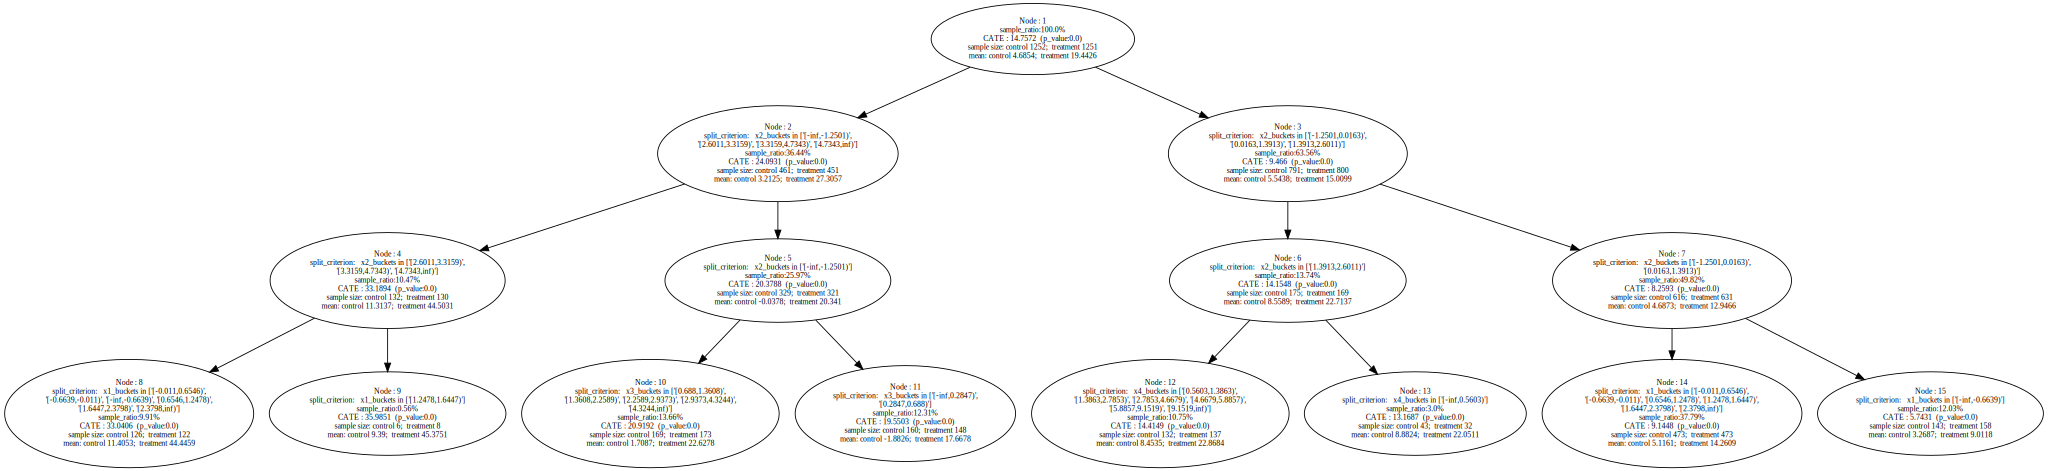

In [15]:
treeplot = hte.treeplot()
treeplot.render('digraph.gv', view=False) # save to file digraph.gv.pdf
treeplot

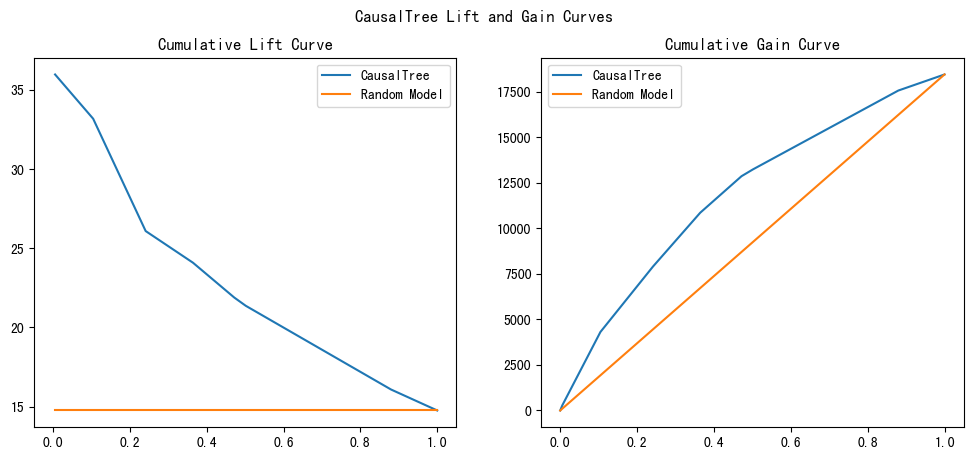

In [16]:
# uplift curve in training data
hte.hte_plot() 

#### DML

Double Machine Learning is a method for estimating (heterogeneous) treatment effects when all potential confounders/controls (factors that simultaneously had a direct effect on the treatment decision in the collected data and the observed outcome) are observed, but are either too many (high-dimensional) for classical statistical approaches to be applicable or their effect on the treatment and outcome cannot be satisfactorily modeled by parametric functions (non-parametric). Both of these latter problems can be addressed via machine learning techniques (see e.g. [Chernozhukov2016](https://arxiv.org/abs/1608.00060)).

The method reduces the problem to first estimating two predictive tasks:

- predicting the outcome from the controls,

- predicting the treatment from the controls;

Then the method combines these two predictive models in a final stage estimation so as to create a model of the heterogeneous treatment efffect. The approach allows for arbitrary Machine Learning algorithms to be used for the two predictive tasks, while maintaining many favorable statistical properties related to the final model (e.g. small mean squared error, asymptotic normality, construction of confidence intervals).

In [17]:
from fast_causal_inference.lib.linear_dml import *
Y='y'
T='treatment'
table = 'test_data_small'
features = ['x1', 'x2']
X_fordml = '+'.join(features)
W='x3'
model = LinearDML(Y=Y,T=T,X=X_fordml,W=W, model_y="ols", model_t="ols", cv=2, table=table)
print('\n----summary----')
print(model.summary())
print(model.effect(T0=0.1, T1=0.2))



----summary----
		Coefficient Results
		Estimate    Std. Error	t value	    Pr(>|t|)
x0		1.892371    0.177398    10.667398   0.0         
x1		0.165999    0.088112    1.883959    0.0596      

		CATE Intercept Results
		Estimate    Std. Error	t value	    Pr(>|t|)
cate_intercept	14.922794   0.175118    85.215847   0.0         

                predict
0      2.63473118788891
1    2.1480790927028437
2    1.3141723892660662
3    1.6124674024754606
4   -0.4971570208151599
..                  ...
95   1.3626308499210575
96    4.449547263101854
97   1.3435940175775773
98    2.087307758742835
99   0.3916806442825673

[100 rows x 1 columns]


In [18]:

from fast_causal_inference.lib.linear_dml import NonParamDML

Y='y'
T='treatment'
table = 'test_data_small'
features = ['x1', 'x2']
X_fordml = '+'.join(features)
W='x7_needcut'

model = NonParamDML(table=table, Y=Y,T=T,X=X_fordml, model_y='Ols', model_t='Ols', cv=2)
print('\n----summary----')
print(model.summary())


----summary----
		Coefficient Results
		Estimate    Std. Error	t value	    Pr(>|t|)
x0		1.918443    0.186487    10.28727    0.0         
x1		0.166828    0.092657    1.800496    0.071812    

		CATE Intercept Results
		Estimate    Std. Error	t value	    Pr(>|t|)
cate_intercept	15.03349    0.184124    81.648869   0.0         



#### Model Evaluation

Since actual uplift can't be observed for each individual, measure the uplift over a group of customers.

Uplift Curve: plots the real cumulative uplift across the population
- First, rank the test dataframe order by the predict uplift.
- Next, calculate the cumulative percentage of visits in each group (treatment or control).
- Finally, calculate the group's uplift at each percentage.


running, please wait
donetime cost: 1.787272089975886 Seconds
running, please wait
donetime cost: 1.657722717965953 Seconds
running, please wait
donetime cost: 0.37403148401062936 Seconds
select lift(effect,y,treatment,100,true) from test_data_small_1699004591_test_pred limit 100000
                   ratio                lift                 gain  \
0   0.009908838684106223  33.518487128716934  0.33212928189374685   
1   0.019817677368212445   33.46010017620829   0.6631014700001644   
2   0.029726516052318668  33.669998144735125   1.0008917403310085   
3    0.03963535473642489   35.67300531609918    1.413912220217962   
4    0.04954419342053112   35.00687186046572   1.7343872305026617   
..                   ...                 ...                  ...   
95    0.9595719381688466   15.56469118895385   14.935440891184014   
96    0.9696789536266349  15.493776456203692   15.023988941776588   
97    0.9797859690844233  15.411626881509509   15.100095779267342   
98    0.9898929845422116  

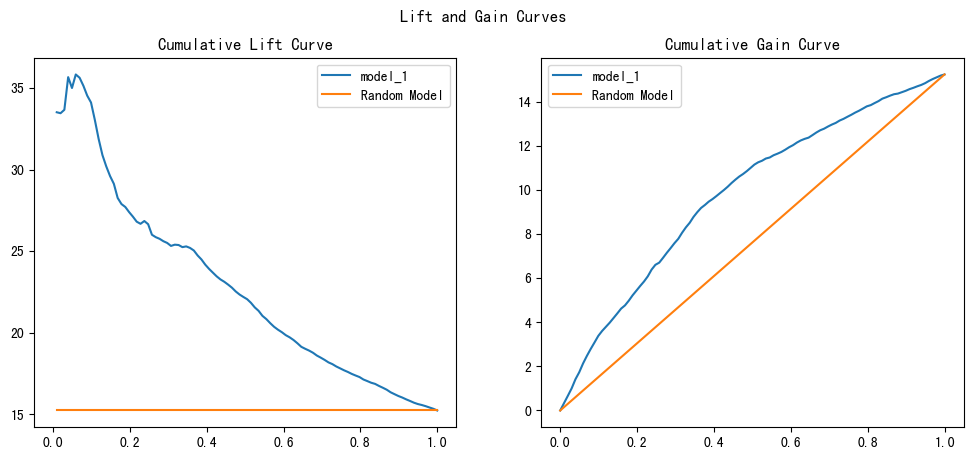

In [19]:

from fast_causal_inference.lib.causaltree import CausalTree
from fast_causal_inference.lib.metrics import *

table_test_predict = f'{table_test}_pred'
# clickhouse_drop_view(clickhouse_view_name=table_test_predict) # drop table
hte.effect_2_clickhouse(table_test_predict,
                        table_input=table_test,
                        keep_col='*')
tmp1 = get_lift_gain("effect", Y, T, table_test_predict,discrete_treatment=True, K=100)
print(tmp1)
hte_plot([tmp1])

# Other tools 

### create/drop  table


In [24]:
fast_causal_inference.clickhouse_create_view(
                            clickhouse_view_name="a20231017", 
                            sql_statement="""
                            WITH (
                                    SELECT
                                            OlsState(y,x1,x2) AS model
                                    FROM
                                            test_data_small
                                   ) AS model
                              SELECT
                                    evalMLMethod (model,x1,x2) AS y_pre
                              FROM
                                    test_data_small
                              limit 10""",
                          is_sql_complete=True, 
                          is_force_materialize=True,  
                          is_use_local=False)


running, please wait
donetime cost: 0.9631054069614038 Seconds


In [25]:
fast_causal_inference.clickhouse_drop_view(clickhouse_view_name="a20231017") 


running, please wait
donetime cost: 0.5709692609962076 Seconds
